# Cryptocurrency prediction deep learning

### Predicción del precio de cryptomonedas con deep learning

"Projecto" : "Análisis_criptomonedas"  
"Título" : "Predicción del precio de cryptomonedas con deep learning"  
"Autor" : "Cristian García Díaz"  
"Fecha de creación" : "20180821"  
"Fecha de modificación" : "20180826"  
"Fuentes":
>#### Network  
>https://medium.com/activewizards-machine-learning-company/bitcoin-price-forecasting-with-deep-learning-algorithms-eb578a2387a3
>https://www.kaggle.com/ashishpatel26/cryptocurrency-using-keras-lstm
>https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

## Índice
[1. Configuración del entorno](#1)  
[2. Obtención y almacenamiento de los datos](#2)  
[3. Análisis, procesado de los datos y visualización de los datos](#3)  
[4. Predicción aplicando redes neuronales](#4) 

## <a name="1"></a> 1. Configuración del entorno

   - Importar funciones y librerías necesarias    

In [1]:
#Se importan las librerias necesarias
#Gestión de archivos y datos
import os
from datetime import datetime
import pickle
from time import time

#Gráficas
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from random import randint

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers

from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

# Se configura el modo offline
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


## <a name="2"></a> 2. Obtención y almacenamiento de los datos

   - Importar funciones y librerías necesaria.
   - Función para obtener los datos.
   - Almacenar los datos en ficheros.

In [2]:
# Comprobar si no esta creada la carpeta de archivos para almacenar los datos
directorio = "cryptocurrency_analysis_files"
if not os.path.exists(directorio):
    os.mkdir(directorio)

In [3]:
#Se añaden los datos de Bitcoin
# Se define una función get_json_data para cargar los datos de la API Poloniex
"""pickle --> para no descargar de nuevo los mismo datos"""
"""La función devuelve un Dataframe Pandas"""

def get_json_data(json_url,cache_path):
    cache_path = directorio +'\{}.pkl'.format(cache_path)
    """Descargamos en cache los datos en formato json"""
    try:
        f = open(cache_path,'rb')
        df = pickle.load(f)
        print('Dataset {} cargado del cache'.format(json_url))
    except (OSError,IOError) as e:
        print('Descargando datos {} mediante la API Poloniex'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cargado {} de {} en el cache'.format(json_url,cache_path))
    return df

In [4]:
# Se define la función genera las peticiones vía HTTP a Poloniex API y se llamará a la función get_json_data para guardar los datos obtenidos
base_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date = datetime.now()
# Periodos válidos: '15m': 900, '5m': 300, '30m': 1800, '4h': 14400, '2h': 7200, '1d': 86400
period = 86400

def get_crypto_data(poloniex_pair):
    '''Captura de los datos de criptomonedas de la API Poliniex'''
    json_url = base_url.format(poloniex_pair,start_date.timestamp(),end_date.timestamp(),period)
    data_df = get_json_data(json_url,poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

# URL de ejemplo: https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420066800.0&end=1483225200.0&period=86400

In [5]:
# Diccionario altcoins formado por un dataframe por cada criptomoneda.
# Cada dataframe contiene el ratio medio de cammbio entre altcoins y BTC.
#altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']
altcoins = ['BTC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'USDT_{}'.format(altcoin)
    
    BTC_price_real_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = BTC_price_real_df

Dataset https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1420066800.0&end=1535994788.398241&period=86400 cargado del cache


## <a name="3"></a> 3. Análisis, procesado de los datos y visualización de los datos

   - Función para visualizar los datos.
   - Visualizar los datos.

In [6]:
# Se define la función para visualizar los datos
def df_scatter(df, title,seperate_y_axis=False, y_axis_label='',scale='linear',initial_hide=False):
    # Se definen la lista de los nombres de cada dataframe como una lista label_arr = ['BITSTAMP', 'COINBASE', 'ITBIT', 'KRAKEN']
    label_arr = list(df)
    # Aplicamos una función lambda para mapear cada columnas y asignar la etiqueta correspondiente
    # Se guarda como otra lista series_arr
    series_arr = list(map(lambda col:df[col],label_arr))
    
    # Se definen los parametros de la salida gráfica
    layout = go.Layout(
        title = title,
        legend = dict(orientation='h'),
        xaxis = dict(type='date'),
        yaxis = dict(
            title = y_axis_label, 
            showticklabels = not seperate_y_axis,
            type = scale
        )
    )
    
    # Se define la configuración del eje y
    y_axis_config = dict(
        overlaying = 'y',
        showticklabels = False,
        type = scale
    )
    
    # Se define la visibilidad
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Se define la forma para cada serie de datos
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
        x = series.index,
        y = series,
        name = label_arr[index],
        visible = visibility
        )
        
        #Añadir un eje separado para cada serie
        if seperate_y_axis:
            trace['yaxis'] = 'y{format}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config
        trace_arr.append(trace)
    
    fig = go.Figure(data = trace_arr, layout = layout)
    py.iplot(fig)

In [7]:
BTC_price_real_df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-02-19,244.00,244.000,225.00,225.000000,0.193117,46.276313,239.627778
2015-02-20,240.25,245.000,240.25,240.250118,0.230429,55.894897,242.568479
2015-02-21,245.00,245.000,245.00,245.000000,0.060091,14.722239,245.000000
2015-02-22,235.00,249.000,235.00,245.000000,0.539055,129.121248,239.532608
2015-02-23,235.00,235.001,235.00,235.000002,0.410926,96.567562,235.000062


In [8]:
BTC_price_real_df.tail()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-08-22,6354.767602,6894.597094,6255.608559,6479.132290,2172.958589,1.429791e+07,6579.926417
2018-08-23,6530.616799,6567.216243,6344.410970,6354.767602,592.459626,3.817506e+06,6443.486423
2018-08-24,6685.522183,6718.000000,6458.002476,6525.836537,759.907347,4.998491e+06,6577.763106
2018-08-25,6726.091103,6789.000000,6665.000000,6693.306879,519.285013,3.486018e+06,6713.112009
2018-08-26,6672.484700,6778.395678,6571.297810,6726.258293,449.810054,2.998773e+06,6666.755151


In [9]:
# Gráfico del precio del BTC
btc_trace = go.Scatter(x=BTC_price_real_df.index, y=BTC_price_real_df['close'])
py.iplot([btc_trace])

In [10]:
# Se llama a la función df_scatter para mostrar los precios BTC de los exchanges
df_scatter(BTC_price_real_df[['close','open']], 'Precio BTC (USD)')
#BTC_price_real_df[['open','close']]

In [11]:
# Se llama a la función df_scatter para mostrar los precios BTC de los exchanges
df_scatter(BTC_price_real_df[['open','close','low','high']], 'Precio BTC (USD)')

In [12]:
#Estadísticas básicas de los datos
BTC_price_real_df.describe()

,close,high,low,open,quoteVolume,volume,weightedAverage
count,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1.285000e+03,1285.000000
mean,2941.746722,3047.614370,2807.182721,2936.935794,3376.588062,1.627160e+07,2927.950550
std,3852.003605,4023.559003,3632.777664,3851.519821,5947.444633,3.375669e+07,3825.900868
min,178.719313,219.010000,99.000000,191.300000,0.000000,0.000000e+00,207.450144
25%,403.841623,415.018697,384.332000,399.000004,29.182476,1.136105e+04,403.318716
50%,743.426553,755.000000,728.289801,742.359480,691.344328,6.215580e+05,739.531856
75%,4787.657550,4900.000000,4664.633844,4770.000000,4504.282267,1.831713e+07,4789.414434
max,19223.000000,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652


## <a name="4"></a> 4. Predicción aplicando redes neuronales

   - Visualizar los datos.
   - Transformación de los datos
   - Aplicar las redes neuronales
   - Visualizar los resultados
   - Calcular errores
   
  
   >https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

In [13]:
#Copiamos los datos a un DF nuevo para poder trabajar con él sin afectar a los datos originales
BTC_price_transform = BTC_price_real_df

In [14]:
# Comprobamos si hay datos que sean nulos en cualquier lugar del DF
# Estamos de suerte no hay datos nulos
BTC_price_transform.isnull().any()

close              False
high               False
low                False
open               False
quoteVolume        False
volume             False
weightedAverage    False
dtype: bool

In [15]:
# Cantidad de observaciones
BTC_price_transform.shape

(1285, 7)

In [16]:
#Cogemos el precio medio de Bitcoin para realizar el análisis
BTC_daily_price = BTC_price_transform['weightedAverage']

In [17]:
BTC_daily_price.head()

date
2015-02-19    239.627778
2015-02-20    242.568479
2015-02-21    245.000000
2015-02-22    239.532608
2015-02-23    235.000062
Name: weightedAverage, dtype: float64

In [18]:
BTC_daily_price.tail()

date
2018-08-22    6579.926417
2018-08-23    6443.486423
2018-08-24    6577.763106
2018-08-25    6713.112009
2018-08-26    6666.755151
Name: weightedAverage, dtype: float64

In [19]:
# Estadísticas básicas del precio
BTC_daily_price.describe()

count     1285.000000
mean      2927.950550
std       3825.900868
min        207.450144
25%        403.318716
50%        739.531856
75%       4789.414434
max      19236.130652
Name: weightedAverage, dtype: float64

In [20]:
# Forma del Dataframe
BTC_price_transform.shape

(1285, 7)

In [21]:
BTC_daily_price.tail(20)

date
2018-08-07    6928.977310
2018-08-08    6420.115197
2018-08-09    6434.195031
2018-08-10    6280.061701
2018-08-11    6163.127208
2018-08-12    6305.955896
2018-08-13    6305.831145
2018-08-14    6013.598796
2018-08-15    6397.564576
2018-08-16    6338.763398
2018-08-17    6479.407756
2018-08-18    6425.964962
2018-08-19    6423.013141
2018-08-20    6371.393574
2018-08-21    6389.253394
2018-08-22    6579.926417
2018-08-23    6443.486423
2018-08-24    6577.763106
2018-08-25    6713.112009
2018-08-26    6666.755151
Name: weightedAverage, dtype: float64

In [22]:
# Crear los datos de entreno, test y evaluación
# Entreno
train_from_date = '2016-11-22'
train_end_date =  '2018-06-22'
# Test
test_from_date = '2018-06-23'
test_end_date = '2018-08-16'
# Evaluación
evaluation_from_date = '2018-08-17'
evaluation_end_date = '2018-08-22'

In [23]:
df_train = BTC_daily_price.loc[train_from_date:train_end_date]
df_test = BTC_daily_price.loc[test_from_date:test_end_date]
df_evaluation = BTC_daily_price.loc[evaluation_from_date:evaluation_end_date]

In [24]:
print(df_train.size," días de entreno\n",df_test.size," días de test\n",df_evaluation.size," días de evaluación\n")

578  días de entreno
 55  días de test
 6  días de evaluación



In [25]:
train_days = BTC_daily_price.loc[train_from_date:train_end_date].count()
test_days = BTC_daily_price.loc[test_from_date:test_end_date].count()
evalutacion_days = BTC_daily_price.loc[evaluation_from_date:evaluation_end_date].count()
print(train_days, " desde ",train_from_date," hasta ",train_end_date )
print(test_days, " desde ",test_from_date," hasta ",test_end_date )
print(evalutacion_days, " desde ",evaluation_from_date," hasta ",evaluation_end_date )

578  desde  2016-11-22  hasta  2018-06-22
55  desde  2018-06-23  hasta  2018-08-16
6  desde  2018-08-17  hasta  2018-08-22


In [26]:
"""
# Preparación para partir el Dataframe para obtener los datos para entrenanmiento y para el test
# Días totales
d0 = datetime(2016, 11, 2)
d1 = datetime(2018, 8, 17)
#
#d0 = datetime(2015, 2, 20)
#d1 = datetime(2018, 8, 17)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = datetime(2018, 6, 23)
d1 = datetime(2018, 8, 22)
#d0 = datetime(2018, 6, 23)
#d1 = datetime(2018, 8, 22)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = datetime(2018, 8, 17)
d1 = datetime(2018, 8, 22)
#d0 = datetime(2018, 8, 17)
#d1 = datetime(2018, 8, 22)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

# 1275 61 6 --> RSM 641.125
# 654 61 6 --> RSM 214.927
# 654 61 6 --> RSM 193.449
"""

'\n# Preparación para partir el Dataframe para obtener los datos para entrenanmiento y para el test\n# Días totales\nd0 = datetime(2016, 11, 2)\nd1 = datetime(2018, 8, 17)\n#\n#d0 = datetime(2015, 2, 20)\n#d1 = datetime(2018, 8, 17)\ndelta = d1 - d0\ndays_look = delta.days + 1\nprint(days_look)\n\nd0 = datetime(2018, 6, 23)\nd1 = datetime(2018, 8, 22)\n#d0 = datetime(2018, 6, 23)\n#d1 = datetime(2018, 8, 22)\ndelta = d1 - d0\ndays_from_train = delta.days + 1\nprint(days_from_train)\n\nd0 = datetime(2018, 8, 17)\nd1 = datetime(2018, 8, 22)\n#d0 = datetime(2018, 8, 17)\n#d1 = datetime(2018, 8, 22)\ndelta = d1 - d0\ndays_from_end = delta.days + 1\nprint(days_from_end)\n\n# 1275 61 6 --> RSM 641.125\n# 654 61 6 --> RSM 214.927\n# 654 61 6 --> RSM 193.449\n'

In [27]:
"""
# Separar en Dataframe los modelos de entreno y de test

# df_train= BTC_daily_price[len(BTC_daily_price)-days_look-days_from_end
#                          :len(BTC_daily_price)-days_from_train]
# df_train= BTC_daily_price[Desde -->1285 total de días -  654 días mirados - 6 dias hasta el final
#                           Hasta -->:1285 total de días - 61 días desde el entreno]
# 599 días de entreno
df_train= BTC_daily_price[len(BTC_daily_price)-days_look-days_from_end:len(BTC_daily_price)-days_from_train]

# df_test = BTC_daily_price[len(BTC_daily_price)-days_from_train:]
#                           
# df_test = BTC_daily_price[Desde --> 1285 total de días - 61 días desde el entreno:
#                           Hasta --> Final]
# 61 días de test
df_test= BTC_daily_price[len(BTC_daily_price)-days_from_train:]

print(len(df_train), len(df_test))
"""

'\n# Separar en Dataframe los modelos de entreno y de test\n\n# df_train= BTC_daily_price[len(BTC_daily_price)-days_look-days_from_end\n#                          :len(BTC_daily_price)-days_from_train]\n# df_train= BTC_daily_price[Desde -->1285 total de días -  654 días mirados - 6 dias hasta el final\n#                           Hasta -->:1285 total de días - 61 días desde el entreno]\n# 599 días de entreno\ndf_train= BTC_daily_price[len(BTC_daily_price)-days_look-days_from_end:len(BTC_daily_price)-days_from_train]\n\n# df_test = BTC_daily_price[len(BTC_daily_price)-days_from_train:]\n#                           \n# df_test = BTC_daily_price[Desde --> 1285 total de días - 61 días desde el entreno:\n#                           Hasta --> Final]\n# 61 días de test\ndf_test= BTC_daily_price[len(BTC_daily_price)-days_from_train:]\n\nprint(len(df_train), len(df_test))\n'

In [28]:
"""
print(len(BTC_daily_price)-days_look-days_from_end,len(BTC_daily_price)-days_from_train)
print(len(BTC_daily_price),-days_look-days_from_end,len(BTC_daily_price),-days_from_train)
print(len(BTC_daily_price)-days_from_train)
print(len(BTC_daily_price),-days_from_train)
"""

'\nprint(len(BTC_daily_price)-days_look-days_from_end,len(BTC_daily_price)-days_from_train)\nprint(len(BTC_daily_price),-days_look-days_from_end,len(BTC_daily_price),-days_from_train)\nprint(len(BTC_daily_price)-days_from_train)\nprint(len(BTC_daily_price),-days_from_train)\n'

In [29]:
df_train.head()

date
2016-11-22    742.560453
2016-11-23    740.845351
2016-11-24    736.072088
2016-11-25    736.499169
2016-11-26    732.672530
Name: weightedAverage, dtype: float64

In [30]:
df_train.tail()

date
2018-06-18    6592.413253
2018-06-19    6732.616245
2018-06-20    6674.112540
2018-06-21    6726.923392
2018-06-22    6187.652025
Name: weightedAverage, dtype: float64

In [31]:
df_test.head()

date
2018-06-23    6120.536737
2018-06-24    5926.860402
2018-06-25    6216.814384
2018-06-26    6169.845945
2018-06-27    6075.170946
Name: weightedAverage, dtype: float64

In [32]:
df_test.tail()

date
2018-08-12    6305.955896
2018-08-13    6305.831145
2018-08-14    6013.598796
2018-08-15    6397.564576
2018-08-16    6338.763398
Name: weightedAverage, dtype: float64

In [33]:
df_evaluation.head()

date
2018-08-17    6479.407756
2018-08-18    6425.964962
2018-08-19    6423.013141
2018-08-20    6371.393574
2018-08-21    6389.253394
Name: weightedAverage, dtype: float64

In [34]:
df_evaluation.tail()

date
2018-08-18    6425.964962
2018-08-19    6423.013141
2018-08-20    6371.393574
2018-08-21    6389.253394
2018-08-22    6579.926417
Name: weightedAverage, dtype: float64

In [35]:
# Para estimar los parametros de nuestros datos porque podrían ser útiles para modelos posteriores.
# Si se quieren predecir los datos hau que comprobar si los datos son estacionarios.
# Si trienen factores de estacionalidad o tendencia.
working_data = [df_train, df_test]
working_data = pd.concat(working_data)
# Se resetea el indice ["index:date", "weightedAverage:value"] --> ["index:ID","date:value","weightedAverage:value"]
working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
# Se establece el indice date
working_data = working_data.set_index('date')

In [36]:
working_data.tail()

,weightedAverage
date,
2018-08-12,6305.955896
2018-08-13,6305.831145
2018-08-14,6013.598796
2018-08-15,6397.564576
2018-08-16,6338.763398


In [37]:
# Comprobamos los datos
working_data.count()

weightedAverage    633
dtype: int64

In [38]:
# Se realiza una descomposición estacional de los datos para estimar su tendencia y estacionalidad.
# Puede ver los movimientos reales de los precios en el gráfico de abajo ("observados"), así como la tendencia
# y estacionalidad de nuestros datos.

s = sm.tsa.seasonal_decompose(working_data.weightedAverage.values, freq=90)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Tendencia',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Estacionalidad',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))
trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residuos',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))
trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observaciones',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Descomposición estacional', xaxis = dict(title = 'Tiempo'), yaxis = dict(title = 'Precio en USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Descomposición estacional')


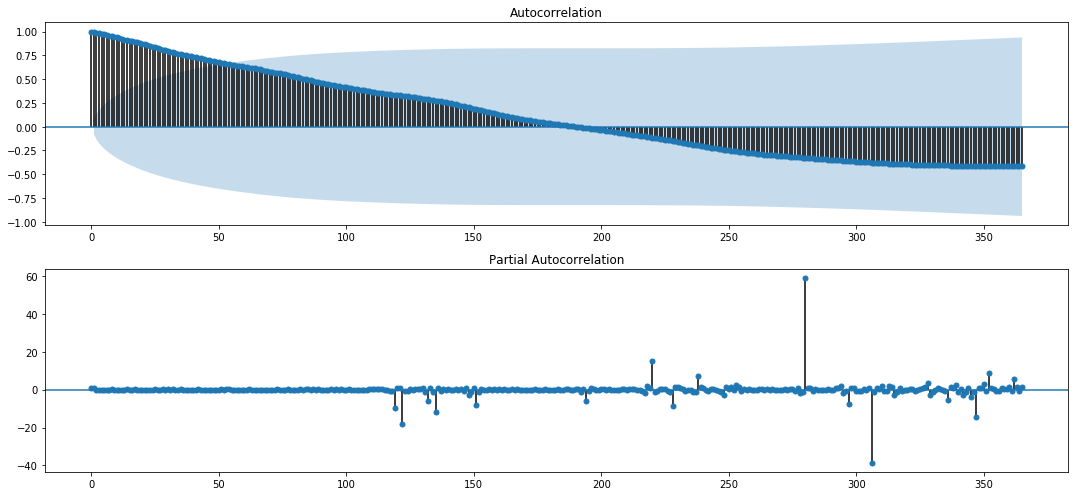

In [39]:
# Ahora realizaremos una autocorrelación para comprobar la similitud entre las observaciones en función al desfase temporal.
# Se pueden encontrar patrones repetitivos en los datos de esta forma.
#1º deribada
#2º deribada
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.weightedAverage.values.squeeze(), lags=365, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.weightedAverage.values.squeeze(), lags=365, ax=ax)
plt.tight_layout()
plt.show()

In [40]:
# Se preparan los datos en Dataframe
df_train = working_data[:-test_days]
df_test = working_data[-test_days:]
df_evaluation = BTC_daily_price[-evalutacion_days:]
df_evaluation = pd.DataFrame(df_evaluation)

In [41]:
working_data.tail(10)

,weightedAverage
date,
2018-08-07,6928.977310
2018-08-08,6420.115197
2018-08-09,6434.195031
2018-08-10,6280.061701
2018-08-11,6163.127208
2018-08-12,6305.955896
2018-08-13,6305.831145
2018-08-14,6013.598796
2018-08-15,6397.564576


In [42]:
df_test.tail(30)

,weightedAverage
date,
2018-07-18,7423.143535
2018-07-19,7409.345600
2018-07-20,7423.877676
2018-07-21,7338.127729
2018-07-22,7443.546033
2018-07-23,7690.305314
2018-07-24,8130.056215
2018-07-25,8244.699137
2018-07-26,8089.408414


In [43]:
df_evaluation.tail(10)

,weightedAverage
date,
2018-08-21,6389.253394
2018-08-22,6579.926417
2018-08-23,6443.486423
2018-08-24,6577.763106
2018-08-25,6713.112009
2018-08-26,6666.755151


In [44]:
# Información entreno
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578 entries, 2016-11-22 to 2018-06-22
Data columns (total 1 columns):
weightedAverage    578 non-null float64
dtypes: float64(1)
memory usage: 9.0 KB


In [45]:
# Información test
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2018-06-23 to 2018-08-16
Data columns (total 1 columns):
weightedAverage    55 non-null float64
dtypes: float64(1)
memory usage: 880.0 bytes


In [46]:
# Información evaluación
df_evaluation.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2018-08-21 to 2018-08-26
Data columns (total 1 columns):
weightedAverage    6 non-null float64
dtypes: float64(1)
memory usage: 96.0 bytes


In [47]:
df_train

,weightedAverage
date,
2016-11-22,742.560453
2016-11-23,740.845351
2016-11-24,736.072088
2016-11-25,736.499169
2016-11-26,732.672530
2016-11-27,733.306066
2016-11-28,732.315227
2016-11-29,732.177748
2016-11-30,737.703313


In [48]:

df_train = df_train.astype('float32')

df_test = df_test.astype('float32')

df_evaluation = df_evaluation.astype('float32')

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train = scaler.fit_transform(df_train)
df_test = scaler.fit_transform(df_test)
df_evaluation = scaler.fit_transform(df_evaluation)

In [50]:
# Se prepara el dataset de acuerdo a los requerimientos del modelo y dividir el conjunto de datos en entrenamiento y prueba.
# Se define la función que crea X e Y etiquetas para el modelo.
# En la predicción secuencial se predicen valores futuros en función de valores anterior y actuales.
# Por tanto, la etiqueta Y es el siguiente punto futuro, mientras que las entradas X son los valores del pasado.
# La cantidad de los valores lo podemos establecer modificadndo el parametro look_back.
# Si look_back=1 entonces se predice el valor actual t basado en el valor anterior (t-1)
# Se convierte el vector en una matriz de valores futuros
# Para cada valor se coge el historico y se vuelve a crear un valor con el valor futuro.
# make predictions
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [51]:
look_back = 1
trainX, trainY = create_dataset(df_train, look_back)
testX, testY = create_dataset(df_test, look_back)

In [52]:
trainX.shape

(576, 1)

In [53]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [54]:
trainX.shape

(576, 1, 1)

In [292]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time()
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)
final_time = time() - start_time

Epoch 1/30
 - 2s - loss: 0.0599
Epoch 2/30
 - 1s - loss: 0.0274
Epoch 3/30
 - 1s - loss: 0.0094
Epoch 4/30
 - 1s - loss: 0.0014
Epoch 5/30
 - 1s - loss: 5.2578e-04
Epoch 6/30
 - 1s - loss: 5.1156e-04
Epoch 7/30
 - 1s - loss: 4.6789e-04
Epoch 8/30
 - 1s - loss: 4.8370e-04
Epoch 9/30
 - 1s - loss: 4.5918e-04
Epoch 10/30
 - 1s - loss: 4.5819e-04
Epoch 11/30
 - 1s - loss: 4.4666e-04
Epoch 12/30
 - 1s - loss: 4.5434e-04
Epoch 13/30
 - 1s - loss: 4.5310e-04
Epoch 14/30
 - 1s - loss: 4.5667e-04
Epoch 15/30
 - 1s - loss: 4.5138e-04
Epoch 16/30
 - 1s - loss: 4.4677e-04
Epoch 17/30
 - 1s - loss: 4.4667e-04
Epoch 18/30
 - 1s - loss: 4.3053e-04
Epoch 19/30
 - 1s - loss: 4.4890e-04
Epoch 20/30
 - 1s - loss: 4.5253e-04
Epoch 21/30
 - 1s - loss: 4.5812e-04
Epoch 22/30
 - 1s - loss: 4.4027e-04
Epoch 23/30
 - 1s - loss: 4.4681e-04
Epoch 24/30
 - 1s - loss: 4.5412e-04
Epoch 25/30
 - 1s - loss: 4.3818e-04
Epoch 26/30
 - 1s - loss: 4.5886e-04
Epoch 27/30
 - 1s - loss: 4.4153e-04
Epoch 28/30
 - 1s - loss: 

In [331]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2095146.02 RMSE
Test Score: 2111885.90 RMSE


In [332]:
# Tiempo de ejecución
print('Tiempo de ejecución de la red neural es de: {0:.3f}'.format(final_time))

Tiempo de ejecución de la red neural es de: 35.109


In [295]:
trainPredict = trainPredict.reshape(len(trainPredict),)

In [296]:
trainPredict.shape

(576,)

In [297]:
trainY = trainY.reshape(-1)

In [298]:
trainY.shape

(576,)

In [329]:
df_train.shape

(578,)

In [328]:
df_train = df_train.values.reshape(len(df_train),)

In [299]:
predicted_train = trainPredict
observated_train = trainY

In [330]:
# Visualización de 
trace1 = go.Scatter(
    x = np.arange(0, len(predicted_train), 1),
    y = predicted_train,
    mode = 'lines',
    name = 'Predicted',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(df_train)-2, 1),
    y = df_train,
    mode = 'lines',
    name = 'Observaciones',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [302]:
# MSE
print("MSE: %.3f" % mean_squared_error(observated_train, predicted_train))
# RMSE Root Mean Square Error
RMSE = sqrt(mean_squared_error(observated_train, predicted_train))
print('RMSE: %.3f' % RMSE)
from sklearn.metrics import mean_absolute_error
# MAE
print("MAE: %.3f" % mean_absolute_error(observated_train, predicted_train))

MSE: 43.832
RMSE: 6.621
MAE: 3.872


In [303]:
# Ahora se extrae con el formato de fechas y se traza 
Test_Dates =BTC_daily_price.iloc[BTC_daily_price.index>=train_from_date].index

trace1 = go.Scatter(x=Test_Dates, y=observated, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predicted, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

 ## Test

In [304]:
testPredict = testPredict.reshape(len(testPredict),)
testY = testY.reshape(-1)
predicted_test = testPredict
observated_test = testY

In [305]:
# Visualización de 
trace1 = go.Scatter(
    x = np.arange(0, len(predicted_test), 1),
    y = predicted_test,
    mode = 'lines',
    name = 'Predicted',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(observated_test), 1),
    y = observated_test,
    mode = 'lines',
    name = 'Observaciones',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [306]:
# MSE
print("MSE: %.3f" % mean_squared_error(observated_test, predicted_test))
# RMSE Root Mean Square Error
RMSE = sqrt(mean_squared_error(observated_test, predicted_test))
print('RMSE: %.3f' % RMSE)
from sklearn.metrics import mean_absolute_error
# MAE
print("MAE: %.3f" % mean_absolute_error(observated_test, predicted_test))

MSE: 786.797
RMSE: 28.050
MAE: 20.438


In [307]:
# Ahora se extrae con el formato de fechas y se traza 
Test_Dates =BTC_daily_price.iloc[BTC_daily_price.index>=test_from_date].index

trace1 = go.Scatter(x=Test_Dates, y=observated_test, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predicted_test, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')